In [11]:
import numpy as np
import pandas as pd
from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Dropout, Conv2D, GlobalMaxPool2D, GlobalAveragePooling2D
from keras.optimizers import SGD, Adam
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.applications import vgg16
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG19
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

#for model deployement 
import os
import cv2
import numpy as np
from keras.models import model_from_json
from keras.utils import img_to_array

In [6]:
train_data_path = '/home/becode/Desktop/NPL/venv/data/train/'
test_data_path = '/home/becode/Desktop/NPL/venv/data/test/'
from keras.preprocessing.image import ImageDataGenerator
img_shape = 48
batch_size = 64
train_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
        rotation_range=10,
        zoom_range=0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,                                        
        fill_mode='nearest',
    )
test_preprocessor = ImageDataGenerator(
    rescale = 1 / 255.,
)

train_data = train_preprocessor.flow_from_directory(
    train_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size,
    subset='training', 
)

test_data = test_preprocessor.flow_from_directory(
    test_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode="rgb",
    shuffle=False,
    batch_size=batch_size,
)

Found 34267 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [12]:

image_input = keras.layers.Input(shape=(48,48, 3))
baseModel=VGG19(include_top=False,weights="imagenet",input_tensor=image_input)
for i,layer in enumerate(baseModel.layers):
  layer.trainable=False 
baseModel.summary()  

80134624/80134624 [==============================] - 48s 1us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                             

In [14]:

# add a global spatial average pooling layer
x = baseModel.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(7, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=baseModel.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in baseModel.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
                  metrics=['accuracy', tf.metrics.Precision()])

In [15]:
import keras
# Define some callbacks
class LossAndErrorPrintingCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(
            "The average loss for epoch {} is {:7.2f} "
            "- accuracy is {:7.2f} "
            "- precision is {:7.2f}.".format(
                epoch, logs["loss"], logs["accuracy"], logs['precision']
            )
        )

earlystopping = EarlyStopping(
    monitor="val_accuracy", 
    patience=15, 
    verbose=1, 
    mode="auto", 
    restore_best_weights=True)

rlrop = ReduceLROnPlateau(
    monitor="val_accuracy", 
    mode="max", 
    patience=5, 
    factor=0.5, 
    min_lr=1e-6, 
    verbose=1)

# Create a list of callbacks 
callbacks = [LossAndErrorPrintingCallback(), earlystopping, rlrop]

In [18]:
model.fit(train_data,
                        epochs=15, 
                        batch_size=16,
                        validation_data=test_data,
                        verbose=2,
                        callbacks=callbacks
                       )
model.summary()

Epoch 1/15


2023-05-11 16:00:21.378378: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-11 16:09:33.789180: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


The average loss for epoch 0 is    1.59 - accuracy is    0.39 - precision is    0.60.
536/536 - 754s - loss: 1.5873 - accuracy: 0.3860 - precision: 0.5983 - val_loss: 1.5511 - val_accuracy: 0.3941 - val_precision: 0.6048 - lr: 0.0010 - 754s/epoch - 1s/step
Epoch 2/15


In [ ]:
model.save('tf_model', save_format= "tf")

INFO:tensorflow:Assets written to: tf_model/assets


INFO:tensorflow:Assets written to: tf_model/assets


In [3]:
import tensorflow as tf
my_model = tf.keras.saving.load_model('/content/drive/MyDrive/Colab Notebooks/data/tf_model', compile=False)
probability_model = tf.keras.Sequential([my_model, tf.keras.layers.Softmax()])

In [4]:
from keras.preprocessing import image
import numpy as np
# Add the image to a batch where it's the only member.
img = '/data/PrivateTest_1109992.jpg'
#img = 'data/archive/test/disgust/PrivateTest_3881740.jpg'
img = image.image_utils.load_img(img, target_size=(48, 48))
y = image.image_utils.img_to_array(img)
y = np.expand_dims(y, axis=0)

# pass the list of multiple images np.vstack()[:10]
# images = np.vstack([x, y])
classes = probability_model.predict(y, verbose=0, batch_size=1)tf.keras.preprocessing.image.load_img
predicted_label = np.argmax(classes)
print(predicted_label)
classes

6


array([[0.13756643, 0.12352538, 0.15391998, 0.13458368, 0.14119089,
        0.13824719, 0.17096649]], dtype=float32)

In [ ]:
classes = train_data.class_indices
classes

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [ ]:
# Get predictions

predictions = np.argmax(model.predict(test_data), axis=-1)


# Get the classification report

print(classification_report(test_data.classes, predictions))

113/113 [==============================] - 3s 19ms/step
              precision    recall  f1-score   support

           0       0.32      0.24      0.28       958
           1       0.12      0.02      0.03       111
           2       0.33      0.13      0.19      1024
           3       0.59      0.79      0.67      1774
           4       0.39      0.56      0.46      1233
           5       0.40      0.27      0.32      1247
           6       0.57      0.68      0.62       831

    accuracy                           0.47      7178
   macro avg       0.39      0.39      0.37      7178
weighted avg       0.44      0.47      0.44      7178



In [ ]:
# Get dictionary that connects labels with their integer representations

labels = (train_data.class_indices)
labels

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

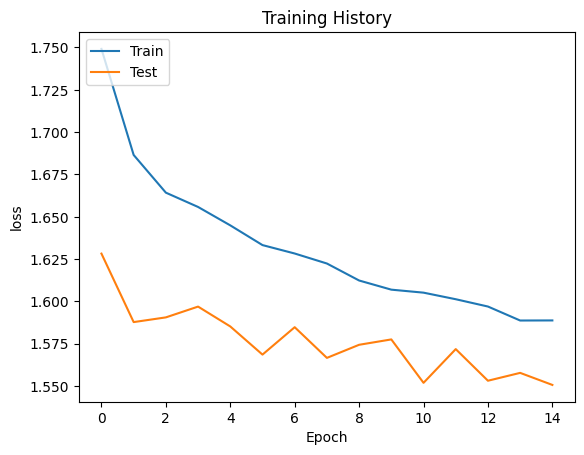

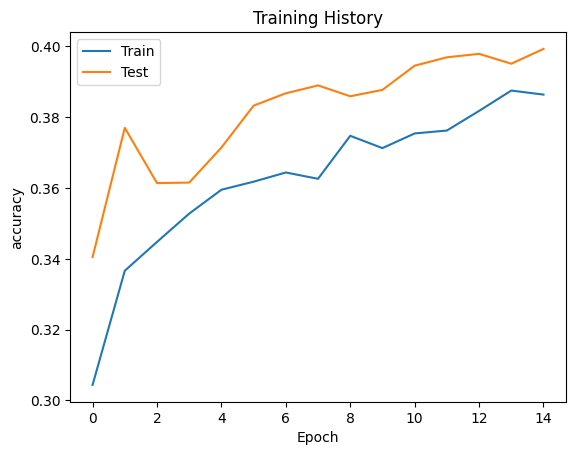

In [17]:
# Show training history

def visualize_train_history(train_history,train,test): 
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[test])
    plt.title("Training History")
    plt.ylabel(train)
    plt.xlabel("Epoch")
    plt.legend(["Train", "Test"], loc="upper left")
    plt.show()

visualize_train_history(history, "loss", "val_loss")
visualize_train_history(history, "accuracy", "val_accuracy")

In [ ]:
preds = model.predict(x)
for cls in train_data.class_indices:
    print(cls+": "+preds[0][train_data.class_indices[cls]])